# Quantitative methods, Assignment Chapter 11

1. (50 points) Implement the Finite Difference method seen in class for
computing the price of a European call. Use the parameters T = 1,
r = 0.05, σ = 0.2, K = 100.

In [1]:
# importing necessary libraries
import numpy as np
from scipy.linalg import solve_banded
import scipy.stats as stats
import math
import matplotlib.pyplot as plt

In [10]:
# initializing parameters for the finite difference method
T = 1.0
K = 100.0
r = 0.05
sigma = 0.2
N = 1000
M = 500
delta_tau = T / N
R = 4.9539
delta_y = R/M

In [3]:
# thomas algorithm to solve the tridiagonal system of equations
def thomas_algorithm(a, b, c, d):
    """
    Solves a tridiagonal system Ax = d where A is defined by vectors a, b, c.
    a: main diagonal of A
    b: upper diagonal of A
    c: lower diagonal of A
    d: right-hand side vector
    """
    n = len(d)
    c_prime = np.zeros(n-1)
    d_prime = np.zeros(n)

    # Modify the first coefficients
    c_prime[0] = c[0] / a[0]
    d_prime[0] = d[0] / a[0]

    # Forward sweep
    for i in range(1, n-1):
        temp = a[i] - b[i-1] * c_prime[i-1]
        c_prime[i] = c[i] / temp
        d_prime[i] = (d[i] - b[i-1] * d_prime[i-1]) / temp

    d_prime[-1] = (d[-1] - b[-2] * d_prime[-2]) / (a[-1] - b[-2] * c_prime[-2])

    # Back substitution
    x = np.zeros(n)
    x[-1] = d_prime[-1]
    for i in range(n-2, -1, -1):
        x[i] = d_prime[i] - c_prime[i] * x[i+1]

    return x

In [4]:
# implementation of finite difference method for black scholes PDE
def finiteDifferenceMethod(T, K, r, sigma, N, M, delta_tau, R, delta_y):
    a = -1.0/2.0*(delta_tau * (sigma**2 / delta_y**2)) + delta_tau*(r - (1.0/2.0)*sigma**2)/(2*delta_y)
    b = 1.0 + delta_tau*(r + (sigma**2/delta_y**2))
    c = delta_tau*(-((r - (1.0/2.0)*sigma**2)/(2*delta_y))/2*delta_y - 1.0/2.0*(sigma**2/delta_y**2))
    # Initialize u_0^i
    u = np.zeros((2*M -1, 1))

    u = np.maximum(np.exp(np.arange(-M+1, M) * delta_y) - K, 0).reshape(2*M -1, 1) #[2M-1 X 1]

    main_diag = b * np.ones(2 * M - 1 )
    upper_diag = c * np.ones(2 * M - 2)
    lower_diag = a * np.ones(2 * M - 2)

    for i in range(N+1):
        B_h = u.copy()
        B_h[2*M-1 -1][0] -= c * (np.exp(M * delta_y) - K*np.exp(-r * (i+1) * delta_tau) )
        u = thomas_algorithm(main_diag, upper_diag, lower_diag, B_h).reshape(2*M -1, 1)

    u = u.reshape(1, 2*M -1 )
    return u

u = finiteDifferenceMethod(T, K, r, sigma, N, M, delta_tau, R, delta_y)
discounted_Option_price = u*np.exp(-r*T)

stock_price = np.exp(np.arange(-M+1, M) * delta_y).reshape(1,2*M -1)

stock_price_slice = stock_price[0][-100:-1]
discounted_Option_price_slice = discounted_Option_price[0][-100:-1]

2. (10 points) What value of R did you choose? Why? Discuss.

As the strike price of the option is given as 100 we choose the current stock price little lower than that, so we choose it as 95. Hence log price is equal to 4.5539. 
As the log prices are normally distributed with highest standard deviation of sigma*sqrt(T) = 0.2*1 = 0.2, 
and as intial log price +-2*(sigma*sqrt(T)) contains nearly 95% of the data in normal distributed sample we choose R = intital log price +-2*(sigma*sqrt(T)) = 4.5539+2*0.2 = 4.9539

3. (10 points) Plot the value of the European call at time 0 for a range of
values of the underlying stock.

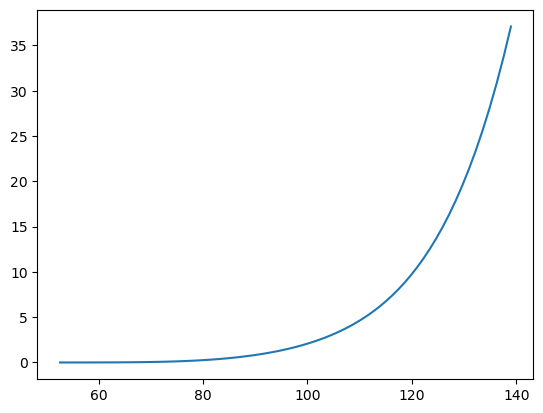

In [5]:
stock_price_slice = stock_price[0][-100:-1]
discounted_Option_price_slice = discounted_Option_price[0][-100:-1]

# plot of value of option vs underlying stock price at time 0
plt.plot(stock_price_slice,discounted_Option_price_slice)

4. (30 points) Compare the computed value with the value obtained by
using the analytical formula and compute the error. Refine the mesh 3
times by multiplying the number of spatial points by 2 and the number
of time steps by 4, each time, and compute the corresponding error.
Do you achieve a convergence of order 2 in space and of order one in
time

Comparing the computed value with the value obtained by using the analytical formula and computing the error.

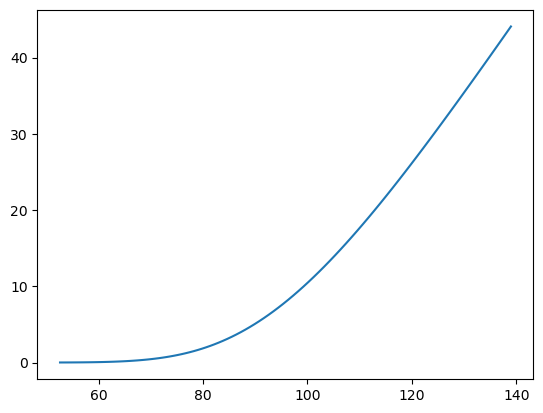

In [6]:
# analytical solution to black scholes equation
def callOptionPriceAnalytical(s, r, sigma, T, K):
    dminus = (math.log(s/K*1.0) + (r-(sigma**2)/2)*T)/(sigma*(T**(0.5)))
    dplus = dminus + sigma*(T**(0.5))
    
    value = s*stats.norm(0, 1).cdf(dplus) - math.exp(-1.0*r*T)*K*stats.norm(0, 1).cdf(dminus)
    
    return value


Option_prices_analytical = np.zeros(len(stock_price_slice))

# finding the value of the european call option using analytical formula
for i in range(len(stock_price_slice)):
    Option_prices_analytical[i] = callOptionPriceAnalytical(stock_price_slice[i], 0.05, 0.2, 1, 100.0)

# plotting the graph of analytical value vs underlying stock price    
plt.plot(stock_price_slice,Option_prices_analytical)
plt.show()

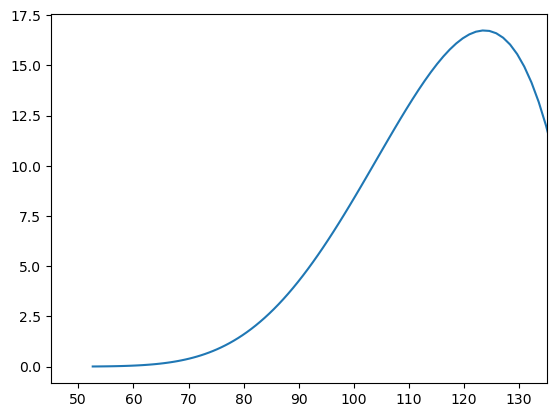

In [7]:
# calculating and plotting the error between 
# solution to black scholes equation using finite difference method and analytical solution
error = np.zeros(len(stock_price_slice))
for i in range(len(stock_price_slice)):
    error[i] = np.abs(discounted_Option_price_slice[i]-Option_prices_analytical[i])

plt.xlim([45, 135])
plt.plot(stock_price_slice,error)
plt.show()

As we can see in the graph, the error is minimum 0 and maximum of around 16

Refining the mesh 3 times by multiplying the number of spatial points by 2 and the number of time steps by 4, each time, and computing the corresponding error

In [8]:
N = 1000*4
M = 500*2
delta_tau = T / N
R = 5.1 # k = 100 log(k) = 4.605
delta_y = R/M

u = finiteDifferenceMethod(T, K, r, sigma, N, M, delta_tau, R, delta_y)
discounted_Option_price = u*np.exp(-r*T)

stock_price = np.exp(np.arange(-M+1, M) * delta_y).reshape(1,2*M -1)

stock_price_slice = stock_price[0][-100:-1]
discounted_Option_price_slice = discounted_Option_price[0][-100:-1]

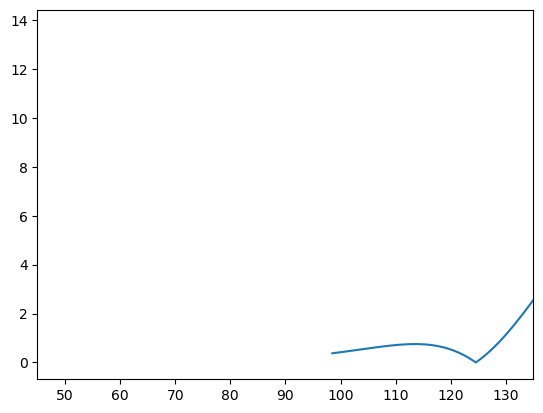

In [9]:
# calculating and plotting the error between 
# solution to black scholes equation using finite difference method and analytical solution
error = np.zeros(len(stock_price_slice))
for i in range(len(stock_price_slice)):
    error[i] = np.abs(discounted_Option_price_slice[i]-Option_prices_analytical[i])

plt.xlim([45, 135])
plt.plot(stock_price_slice,error)
plt.show()

As we can see from the graph the lowest error is 0 and highest error is around 3 to 3.5 which is less than 1/4th of previous maximum error(16), ie the order of convergence is 2 in space and order of 1 in time as expected and overall error decreased to 1/4 th of its previous value